# Similarités entre séries

_recherche d'une mesure de similarité pertinente, associée à une feature representation pertinente_



In [217]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "/root/Documents/PLDAC/data"

In [259]:
#pour rendre le notebook plus clean!
def printMatrice(sim, series):
    plt.figure(figsize=(10,10))
    plt.imshow(sim, cmap='YlGn', interpolation='nearest')
    plt.xticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
    plt.yticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series])
    plt.show()
    
    
"""
J'AI MODIFIÉ ICI 
POUR QU'ON PUISSE DONNER EN ENTREE LE NOM D'UNE SERIE SANS LE NUMERO QUI VIENT AVANT
"_HOUSE" ET "1832_HOUSE"
RENVOIENT LE MEME RESULTAT
"""
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    index = 0
    ch = ("".join(serie.split("_")[1:])).lower()
    for j, name in enumerate(series):
        if ch in ("".join(name.split("_"))).lower():
            index = j
            break
    mdr = [(series[i], a) for i, a in enumerate(sim[index])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k+1]][1:]:
        print("  ", " ".join(b))

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **44 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

### Matrice de similarité:

Nous construisons une matrice de similarité entre séries, de manière à indiquer la ressemblance entre deux séries. Nous commençons par une approche classique qui considère des modèles vectoriels bag-of-words des séries, et effectue une similarité cosinus entre ces vecteurs.

<img src="images/cosinesim.png" width=400/>

Le texte est lemmatisé: cela signifie que tous les mots sont mis sous une forme standard, sans flexion. Il n'y a donc plus de pluriel, plus de temps grammatical, de participe passé... cela constitue un prétraitement efficace pour réduire la taille du dictionnaire.

exemple:

| **mot**      |     **lemme**    |
| ------------- |: -------------: |
| happy, happiness, happy      |        happy       |
|   playing, played, plays      |        play        |
| am, are, is      |        be        |

In [256]:
"""
LES MATRICES QUE J'AI CALCULÉ DE SIMILARITÉ SONT BASÉ SUR LES 100 MOST IMPORTANT SERIES
DONC PAS DE LISTE MANUELEMENT ECRITE
"""
nbSeries = 100
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]

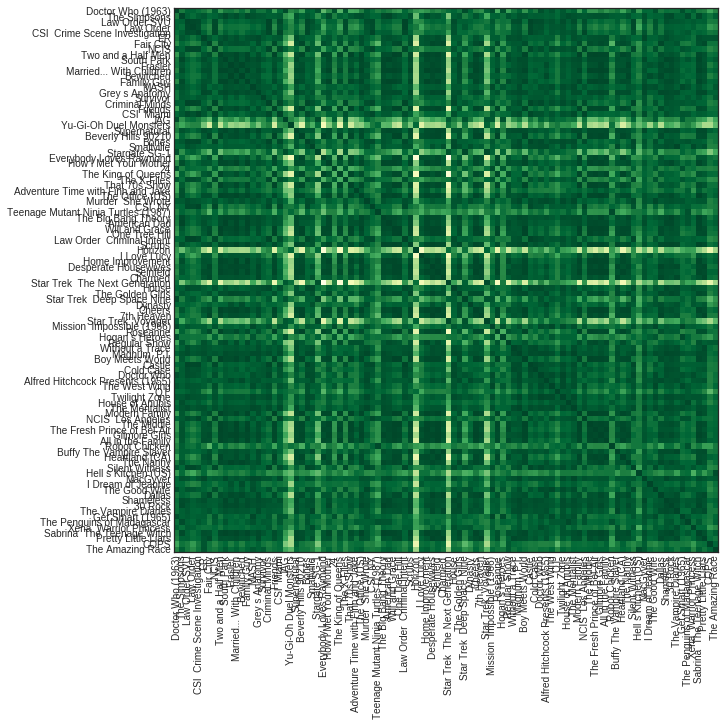

In [257]:
"""
HOP UN PETIT TEST D'OUVERTURE DE MATRICE PRÉCALCULÉE
JE PRÉCISERAI PLUS BAS C QUOI LA DIFFERENCE ENTRE SIM_1_.NPY ET SIM_2_.NPY ...
ET LA NORMALIZATION DONNE DES RESULTATS WTF VAUT MIEUX PAS LA FAIRE
"""
sim = np.load("similarity_matrices/sim_1_.npy")
#sim = normalize(sim, norm='l1', axis=0)

printMatrice(sim, series)

In [260]:
krecommendations(sim, series, '2956_Criminal_Minds', 7)
krecommendations(sim, series, '2567_House', 7)
krecommendations(sim, series, '2469_The_Simpsons', 7)
krecommendations(sim, series, '381_Star_Trek__The_Next_Generation', 7)
krecommendations(sim, series, '196_Smallville', 7)

series les plus proches de Criminal Minds:
   Law Order SVU
   Silent Witness
   Castle
   Law Order  Criminal Intent
   Law Order
   NCIS
   Bones
series les plus proches de House:
   Dallas
   7th Heaven
   Scrubs
   One Tree Hill
   The Golden Girls
   Pretty Little Liars
   Will and Grace
series les plus proches de The Simpsons:
   American Dad
   South Park
   30 Rock
   Sabrina  The Teenage Witch
   Family Guy
   The Big Bang Theory
   The Penguins of Madagascar
series les plus proches de Star Trek  The Next Generation:
   Star Trek  Voyager
   Stargate SG-1
   JAG
   Star Trek  Deep Space Nine
   Doctor Who (1963)
   Horizon
   Yu-Gi-Oh Duel Monsters
series les plus proches de Smallville:
   The Vampire Diaries
   House
   Xena  Warrior Princess
   Buffy The Vampire Slayer
   Magnum  P.I.
   Doctor Who
   Silent Witness


#### Résultat:

Ce modèle parait également à première vue très bon, du moins pour les 5-6 premières recommendations.

Essayons l'approche vecteur de tf-idf, en réglant le DF minimum afin de retirer du corpus les mots trop particuliers à une série, en vue d'étudier son impact sur la similarité:

#### Résultat:

On remarque la présence d'un carré assez sombre en haut à gauche: le modèle a reconnu une certaine similarité entre les séries de type "policier" comme esprits criminels, ou NCIS. Un autre "carré" est aussi présent dans l'image, qui correspond à une certaine similarité entre les séries dites "comiques" comme les simpsons, modern family, south park... un bloc "science-fiction" est aussi présent.

On remarque que le modèle devient mauvais à partir de la 5e recommendation environ: la base de test est trop petite pour permettre de recommender autant de séries.

Etant donné la proximité des résultats des 2 modèles, un problème se pose:

>Comment évaluer la qualité d'un modèle de similarité?

Nous devons utiliser une ou plusieurs mesures de similarité pour évaluer qualitativement nos modèles, afin d'être en mesure de choisir le meilleur.

Dans un premier temps, nous évaluons les performances d'une recommendation en calculant une moyenne de ses scores de rappel, précision, et mesure F1. Une façon de définir les "séries pertinentes" que le système devrait théoriquement prédire est de se baser sur le genre des séries.

#### Les genres des séries nous sont donnés par l'api TVdb:

In [261]:
series_df = pd.read_csv("series.csv")
series_df = series_df.dropna(subset=["genres"])
"""
J'AI CONTINUÉ À UTILISER LA VARIABLE SERIES, DONC ON L'ECRASE PAS
"""
#series = list(series_df["seriesname"])
series_df[["seriesname", "genres"]].head(3)

,seriesname,genres
0,2318_Raising_the_Bar,Drama
1,1159_Rejseholdet_(Unit_One),Drama
2,1821_Til_Death,Comedy


In [262]:
"""
LE BOUT DE CODE BIZARRE QUI COMMENCE PAR 'INDEX = NONE' ET FINI PAR 'P = INDEX'
EST JUSTE UN MOYEN DE TROUVER L'INDEX D'UNE SERIE À PARTIR DE SON NOM, SOIT DANS LA LISTE SERIES, SOIT DANS LE CSV
EN GROS J'ENLEVE LES '_' JE COLLE TOUT LE PUTAIN DE NOM ENSEMBLE APRES AVOIR
ENLEVE LE NUMERO A LA CON ET JE MET EN LOWERCASE
"""

serie = '_The_Simpsons'
index = None
ch = ("".join(serie.split("_")[1:])).lower()
for j, name in enumerate(series):
    x = ("".join(name.split("_")[1:])).lower()
    if ch == x:
        index = j
        break
p = index
mdr = sorted([(series[i], a) for i, a in enumerate(sim[p])], key=lambda x: x[1], reverse=True)

series_genres = list(series_df["seriesname"])

for a, e in mdr[:25]:
    realName = None
    ch = "".join(a.split("_")[1:])
    for j, name in enumerate(series_df["seriesname"]):
        x = "".join(name.split("_")[1:])
        if ch in x:
            realName = name
            break
    if realName is None:
        continue
    print("  ", " ".join(a.split("_")[1:]), "\t\t\t\t ", list(series_df[series_df["seriesname"]==realName]["genres"])[0])

   The Simpsons 				  Animation-Comedy
   American Dad 				  Animation-Comedy
   South Park 				  Animation-Comedy
   30 Rock 				  Comedy
   Sabrina  The Teenage Witch 				  Children-Comedy
   Family Guy 				  Comedy
   The Big Bang Theory 				  Comedy
   The Penguins of Madagascar 				  Animation-Children
   Shameless 				  Comedy-Drama
   How I Met Your Mother 				  Comedy-Romance
   Married... With Children 				  Comedy
   House of Anubis 				  Science-Fiction-Fantasy
   Home Improvement 				  Comedy
   The Office (US) 				  Comedy
   Adventure Time with Finn and Jake 				  Adventure-Animation-Comedy-Fantasy
   Scrubs 				  Comedy
   MacGyver 				  Action-Adventure
   MASH 				  Comedy
   The Fresh Prince of Bel-Air 				  Comedy
   The Mentalist 				  Crime-Drama-Mystery
   Supernatural 				  Action-Drama-Fantasy
   Gilmore Girls 				  Comedy-Drama
   Magnum  P.I. 				  Action-Adventure-Drama
   The Nanny 				  Comedy
   Cheers 				  Comedy


Sur cet exemple sur la série "Les Simpsons", on voit que le système a recommendé plusieurs séries dont le genre n'a rien à voir avec les simpsons: American Horror Story, MacGyver (MacGyver ressemble aux simpsons, vraiment?!), Lost girl, Voyagers, Desperate housewifes...

L'ensemble de métriques précision/rappel/F1 fournit une mesure pertinente: la **précision**. En mesurant la précision, nous évaluons la probabilité **qu'une série recommendée soit une série du même genre**.
Le **rappel**, quant à lui, mesure la probabilité **qu'une série du même genre soit recommendée**.

Le score F1, quant à lui, est la moyenne géométrique de la précision et du rappel:

<img src="images/f1-score.jpg" width=300/>

Nous chercherons à évaluer les performances de nos modèles en considérant comme référence à recommender les **séries du même genre**. Nous prendrons deux références pour une série A: 
- les séries qui ont tous les genres de A: par exemple, si A est du genre action-aventure, nous considérons les séries qui appartiennent toutes au genre action-aventure.
- les séries qui ont un genre en commun avec A: par exemple, si A est du genre action-aventure, toutes les séries qui sont sont action, soit aventure.

In [263]:
#classe implémentant les mesures de rappel/précision/score F1
from utils.evalIRmodel import EvalIRmodel

Construisons la liste des séries pertinentes en terme de similarité pour chaque série: Commencons par les séries du même genre:

In [266]:
import warnings
warnings.filterwarnings(action='once')

pertinent = []

"""
MEME PRINCIPE JE ME SERS BCP DU TMENYIK PRECEDENT POUR TROUVER L'INDEX D'UNE SERIE
LA LISTE INTROUVABLE C POUR VIRER LES SERIES QUI SONT PAS DANS LE CSV, ON LES VIRES DE LA LISTE DE SMILARITÉS
"""
introuvables = []
cleaned = False #juste pour ne pas supprimer plusieurs fois les introuvables
for i, serie in enumerate(series):
    index = None
    ch = "".join(serie.split("_")[1:])
    for j, name in enumerate(series_df["seriesname"]):
        x = "".join(name.split("_")[1:])
        if ch in x:
            index = j
            break
    if index is None:
        introuvables.append(i)
        continue
        
    row = series_df.iloc[index]
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += row["genres"].split("-")
    for i in range(len(genres) - 1):
        regexp += "("+"|".join(genres)+"){1}.*-"
    regexp += "("+"|".join(genres)+"){1}.*"
    neat = []
    for name in list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]):
        tmp = "".join(name.split("_")[1:])
        tmp = tmp.lower()
        neat.append(tmp)
    pertinent.append(neat)

In [267]:
"""
DE MEME LES NOMS SONT EN LOWERCASE SANS NUMERO ET COLLÉS
"""
similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([("".join(a.split("_")[1:])).lower() for a, b in mdr])

similaires

[['doctorwho(1963)',
  'missionimpossible(1966)',
  'jag',
  'startrekdeepspacenine',
  'getsmart(1965)',
  'hogansheroes',
  'doctorwho',
  'stargatesg-1',
  'thegoodwife',
  '24',
  'thewestwing',
  'silentwitness',
  'twilightzone',
  'thex-files',
  'mash',
  'murdershewrote',
  'ncis',
  'criminalminds',
  'xenawarriorprincess',
  'alfredhitchcockpresents(1955)',
  'startrekvoyager',
  'bones',
  'magnump.i.',
  'thementalist',
  'laworder',
  'lawordersvu',
  'house',
  'dynasty',
  'smallville',
  'ncislosangeles'],
 ['thesimpsons',
  'americandad',
  'southpark',
  '30rock',
  'sabrinatheteenagewitch',
  'familyguy',
  'thebigbangtheory',
  'thepenguinsofmadagascar',
  'shameless',
  'howimetyourmother',
  'married...withchildren',
  'houseofanubis',
  'homeimprovement',
  'theoffice(us)',
  'adventuretimewithfinnandjake',
  'scrubs',
  'macgyver',
  'mash',
  'thefreshprinceofbel-air',
  'thementalist',
  'supernatural',
  'gilmoregirls',
  'magnump.i.',
  'thenanny',
  'cheer

Et maintenant, passons à l'évalutation:

In [268]:
"""
HOP UN PETIT CLEAN DES TROUS
"""
if not cleaned:
    for k, index in enumerate(introuvables):
        similaires.pop(index-k)
cleaned = True

In [269]:
"""
VERIFICATION QUE L'ANAL S'EST BIEN PASSÉ
"""
print(len(similaires),len(pertinent))

99 99


In [271]:
"""
TADAAAA PREMIERES PERFORMANCES DE LA MATRICE 1
"""
evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.390
rappel: 0.238
F1: 0.081


In [ ]:
""" 
MAINTENANT JE VAIS PRESENTER TOUTES LES MATRICES DE SIMILARITÉS
"""

""" The variations """
# variation 1 :
#     nbSeries = 100
#     vec_size = 50
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 2 :
#     nbSeries = 100
#     vec_size = 100
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 3 :
#     nbSeries = 100
#     vec_size = 200
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 4 :
#     nbSeries = 100
#     vec_size = 50
#     word_window = 8
#     word_count_min = 5
#     tokenizer = porterStemmer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 5 :
#     nbSeries = 100
#     vec_size = 100
#     word_window = 8
#     word_count_min = 5
#     tokenizer = porterStemmer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 6 :
#     nbSeries = 100
#     vec_size = 200
#     word_window = 8
#     word_count_min = 5
#     tokenizer = porterStemmer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 7 :
#     nbSeries = 100
#     vec_size = 50
#     word_window = 8
#     word_count_min = 5
#     tokenizer = wordNetLemmatizer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 8 :
#     nbSeries = 100
#     vec_size = 100
#     word_window = 8
#     word_count_min = 5
#     tokenizer = wordNetLemmatizer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 9 :
#     nbSeries = 100
#     vec_size = 200
#     word_window = 8
#     word_count_min = 5
#     tokenizer = wordNetLemmatizer_stopWRemove
#     vectorizer = tf-idf ( min df = 1 )
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 10 :
#     nbSeries = 100
#     vec_size = 50
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = count_vectorizer
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 11 :
#     nbSeries = 100
#     vec_size = 100
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = count_vectorizer
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

# variation 12 :
#     nbSeries = 100
#     vec_size = 200
#     word_window = 8
#     word_count_min = 5
#     tokenizer = tokenize_simple
#     vectorizer = count_vectorizer
#     combiner = multiplication ( multiply each word's tf-idf with the word's embedding, then summing all vectors )
#     similarityMeasure = cosine_similarity

In [273]:
"""
MAINTENANT JE VAIS CALCULER LES PERFORMANCES DE CHAQUE VARIATION
CHAUD DEVAAANT 
"""

for i in range(1,13):
    sim = np.load("similarity_matrices/sim_"+str(i)+"_.npy")
    
    similaires = []

    for s in range(len(series)):
        mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
        similaires.append([("".join(a.split("_")[1:])).lower() for a, b in mdr])
    
    for k, index in enumerate(introuvables):
        similaires.pop(index-k)
    
    if(len(similaires)!=len(pertinent)):
        print("introuvables non supprimés")
        break
    
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(similaires, pertinent, k=10)

    print("VARIATION "+str(i))
    print("\n")
    print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
    print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
    print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))
    print("\n\n")

VARIATION 1


precision: 0.390
rappel: 0.238
F1: 0.081



VARIATION 2


precision: 0.391
rappel: 0.238
F1: 0.081



VARIATION 3


precision: 0.392
rappel: 0.238
F1: 0.081



VARIATION 4


precision: 0.405
rappel: 0.239
F1: 0.082



VARIATION 5


precision: 0.404
rappel: 0.239
F1: 0.082



VARIATION 6


precision: 0.401
rappel: 0.238
F1: 0.082



VARIATION 7


precision: 0.394
rappel: 0.238
F1: 0.081



VARIATION 8


precision: 0.394
rappel: 0.238
F1: 0.081



VARIATION 9


precision: 0.393
rappel: 0.238
F1: 0.081



VARIATION 10


precision: 0.396
rappel: 0.238
F1: 0.082



VARIATION 11


precision: 0.398
rappel: 0.238
F1: 0.082



VARIATION 12


precision: 0.394
rappel: 0.238
F1: 0.081



